In [9]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform
import numpy as np
import numpy.random as random

import gym
from PyQt5.QtCore.QProcess import state

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print(f"gymnasium Version: {gymnasium.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
print(f"numpy {np.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-15.1.1-arm64-arm-64bit
Tensor Flow Version: 2.16.2
Keras Version: 3.6.0
gymnasium Version: 0.28.1

Python 3.9.19 (main, May  6 2024, 14:39:30) 
[Clang 14.0.6 ]
Pandas 2.0.3
Scikit-Learn 1.0.2
SciPy 1.10.1
numpy 1.24.0
GPU is available


Episode 100/1000, Total reward: 19.0
Episode 200/1000, Total reward: 15.0
Episode 300/1000, Total reward: 9.0
Episode 400/1000, Total reward: 12.0
Episode 500/1000, Total reward: 27.0
Episode 600/1000, Total reward: 80.0
Episode 700/1000, Total reward: 14.0
Episode 800/1000, Total reward: 18.0
Episode 900/1000, Total reward: 14.0
Episode 1000/1000, Total reward: 23.0


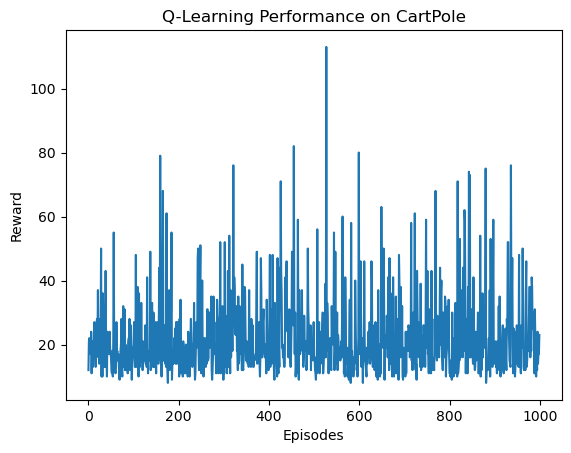

Test Total Reward: 60.0


In [20]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')

n_actions = env.action_space.n
n_states = 24  
learning_rate = 0.1
discount_factor = 0.99
epsilon = 1
epochs = 1000

# Q table
Q = np.zeros((n_states, n_states, n_states, n_states, n_actions))

def discretize_state(state):
    state_bins = [
        np.linspace(-2.4, 2.4, n_states),
        np.linspace(-3.0, 3.0, n_states),
        np.linspace(-0.5, 0.5, n_states),
        np.linspace(-2.0, 2.0, n_states),
    ]
    discrete_state = []
    for i, val in enumerate(state):
        discrete_state.append(np.digitize(val, state_bins[i]) - 1)
    return tuple(discrete_state)

def train():
    rewards = []
    for episode in range(epochs):
        state,_ = env.reset()
        if isinstance(state, dict):
            state = state['state']
        state = discretize_state(state)
        done = False
        total_reward = 0

        while not done:
            # epsilon-greedy
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  
            else:
                action = np.argmax(Q[state])

            next_state, reward, done, _, _ = env.step(action)
            if isinstance(next_state, dict):
                next_state = next_state['state']
            next_state = discretize_state(next_state)

            # update Q
            Q[state][action] = Q[state][action] + learning_rate * (
                reward + discount_factor * np.max(Q[next_state]) - Q[state][action]
            )

            state = next_state
            total_reward += reward

        rewards.append(total_reward)

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{epochs}, Total reward: {total_reward}")

    return rewards

rewards = train()

plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Q-Learning Performance on CartPole')
plt.show()

def test():
    state,_ = env.reset()
    if isinstance(state, dict):
        state = state['state']
    state = discretize_state(state)
    done = False
    total_reward = 0

    while not done:
        action = np.argmax(Q[state])  
        next_state, reward, done, _, _ = env.step(action)
        if isinstance(next_state, dict):
            next_state = next_state['state']
        next_state = discretize_state(next_state)
        state = next_state
        total_reward += reward

    print(f"Test Total Reward: {total_reward}")

test()
